In [1]:
#Import modules
import re
import nltk
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [2]:
#Suppress all warnings
warnings.filterwarnings("ignore")

# Data Collection

In [3]:
#Define a function to read a TSV file into a dataframe
def read_dataframe(tsv_file: str) -> pd.DataFrame:
    df = pd.read_csv(tsv_file, delimiter='\t', dtype=object, header=None) 

    #Assign columns with chosen names
    column_names = [
        'id',               
        'label',             
        'statement',         
        'subjects',          
        'speaker',           
        'speaker_job_title', 
        'state_info',        
        'party_affiliation',
        'count_1', 
        'count_2', 
        'count_3', 
        'count_4', 
        'count_5', 
        'context' 
    ]

    df.columns = column_names
    return df

#Read TSV files
df1 = read_dataframe('train.tsv')
df2 = read_dataframe('test.tsv')
df3 = read_dataframe('valid.tsv')

#Concatenate the dataframes
combined_df = pd.concat([df1, df2, df3], ignore_index=True)

#Drop the selected columns
combined_df = combined_df.drop(['id', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5'], axis=1)
combined_df

,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,context
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,Denver
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,an interview on CNN
...,...,...,...,...,...,...,...,...
12786,half-true,"For the first time in more than a decade, impo...","energy,oil-spill,trade",barack-obama,President,Illinois,democrat,a press conference
12787,mostly-true,Says Donald Trump has bankrupted his companies...,candidates-biography,hillary-clinton,Presidential candidate,New York,democrat,a speech on the economy
12788,true,"John McCain and George Bush have ""absolutely n...",health-care,campaign-defend-america,NaN,"Washington, D.C.",none,a television ad
12789,false,A new poll shows 62 percent support the presid...,health-care,americans-united-change,NaN,NaN,none,an Internet ad.


In [4]:
#Create a new label column based on my criteria (1 is real while 0 is fake)
combined_df['binary_label'] = combined_df['label'].apply(lambda x: 1 if x in ['true', 'mostly-true'] else 0)

#Drop old label column
combined_df = combined_df.drop(['label'], axis=1)
combined_df

,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,context,binary_label
0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer,0
1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.,0
2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,Denver,1
3,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,a news release,0
4,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,an interview on CNN,0
...,...,...,...,...,...,...,...,...
12786,"For the first time in more than a decade, impo...","energy,oil-spill,trade",barack-obama,President,Illinois,democrat,a press conference,0
12787,Says Donald Trump has bankrupted his companies...,candidates-biography,hillary-clinton,Presidential candidate,New York,democrat,a speech on the economy,1
12788,"John McCain and George Bush have ""absolutely n...",health-care,campaign-defend-america,NaN,"Washington, D.C.",none,a television ad,1
12789,A new poll shows 62 percent support the presid...,health-care,americans-united-change,NaN,NaN,none,an Internet ad.,0


# Data Cleaning

In [5]:
#Randomize dataset
combined_df = shuffle(combined_df, random_state=30)

#Reset index after shuffling
combined_df = combined_df.reset_index(drop=True)
combined_df

,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,context,binary_label
0,"Barack Obama will ""raise Social Security taxes.""",social-security,republican-party-florida,NaN,NaN,republican,campaign direct mail,0
1,Donald Trump and Hillary Clinton and Bernie Sa...,health-care,ted-cruz,Senator,Texas,republican,"comments on ""Meet the Press""",0
2,Says allowing the payroll tax holiday to expir...,taxes,jeff-merkley,U.S. Senator,Oregon,democrat,letter to a constituent,1
3,Im not one for name calling.,ethics,ed-rendell,Governor,Pennsylvania,democrat,an interview with Politico's Burgess Everett,0
4,Says Common Core is a federal mandate.,"children,education,federal-budget,states",joe-leibham,NaN,NaN,republican,a news release,0
...,...,...,...,...,...,...,...,...
12786,"Wisconsin is one of the bluest states, but und...","bipartisanship,elections,job-accomplishments,j...",rush-limbaugh,Radio host,NaN,none,a radio commentary,0
12787,American voters remain steadfast in their supp...,immigration,causa-oregon,NaN,Oregon,organization,a website statement,0
12788,She hasn't run a corner store. She hasn't run ...,job-accomplishments,mitt-romney,Former governor,Massachusetts,republican,a TV ad airing in New Hampshire.,0
12789,"If the space-shuttle program is terminated, Ru...",science,kay-bailey-hutchison,U.S. Senator,Texas,republican,a press release.,1


In [6]:
#Remove rows with null values
combined_df = combined_df.dropna()
combined_df

,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,context,binary_label
1,Donald Trump and Hillary Clinton and Bernie Sa...,health-care,ted-cruz,Senator,Texas,republican,"comments on ""Meet the Press""",0
2,Says allowing the payroll tax holiday to expir...,taxes,jeff-merkley,U.S. Senator,Oregon,democrat,letter to a constituent,1
3,Im not one for name calling.,ethics,ed-rendell,Governor,Pennsylvania,democrat,an interview with Politico's Burgess Everett,0
5,Says Debbie Wasserman Schultz has voted for hu...,environment,tim-canova,Nova Southeastern University law professor,Florida,democrat,a post on Medium,1
6,"In 2009, the Small Business Entrepreneurship C...","economy,small-business",ted-strickland,Former Ohio governor,Ohio,democrat,a news release,1
...,...,...,...,...,...,...,...,...
12783,Taxpayers even footed the bill for Perrys trip...,"ethics,taxes,transparency,transportation",kay-bailey-hutchison,U.S. Senator,Texas,republican,a video,0
12784,The annual cost of free tax credits alone paid...,"immigration,taxes",donald-trump,President-Elect,New York,republican,a policy plan on immigration.,0
12788,She hasn't run a corner store. She hasn't run ...,job-accomplishments,mitt-romney,Former governor,Massachusetts,republican,a TV ad airing in New Hampshire.,0
12789,"If the space-shuttle program is terminated, Ru...",science,kay-bailey-hutchison,U.S. Senator,Texas,republican,a press release.,1


In [7]:
#Remove duplicate rows
combined_df = combined_df.drop_duplicates()
combined_df

,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,context,binary_label
1,Donald Trump and Hillary Clinton and Bernie Sa...,health-care,ted-cruz,Senator,Texas,republican,"comments on ""Meet the Press""",0
2,Says allowing the payroll tax holiday to expir...,taxes,jeff-merkley,U.S. Senator,Oregon,democrat,letter to a constituent,1
3,Im not one for name calling.,ethics,ed-rendell,Governor,Pennsylvania,democrat,an interview with Politico's Burgess Everett,0
5,Says Debbie Wasserman Schultz has voted for hu...,environment,tim-canova,Nova Southeastern University law professor,Florida,democrat,a post on Medium,1
6,"In 2009, the Small Business Entrepreneurship C...","economy,small-business",ted-strickland,Former Ohio governor,Ohio,democrat,a news release,1
...,...,...,...,...,...,...,...,...
12783,Taxpayers even footed the bill for Perrys trip...,"ethics,taxes,transparency,transportation",kay-bailey-hutchison,U.S. Senator,Texas,republican,a video,0
12784,The annual cost of free tax credits alone paid...,"immigration,taxes",donald-trump,President-Elect,New York,republican,a policy plan on immigration.,0
12788,She hasn't run a corner store. She hasn't run ...,job-accomplishments,mitt-romney,Former governor,Massachusetts,republican,a TV ad airing in New Hampshire.,0
12789,"If the space-shuttle program is terminated, Ru...",science,kay-bailey-hutchison,U.S. Senator,Texas,republican,a press release.,1


In [8]:
#Define a list of columns
feature_columns = ['statement', 
                    'subjects', 
                    'speaker', 
                    'speaker_job_title', 
                    'state_info', 
                    'party_affiliation', 
                    'context']  

#Lowercase all string columns
combined_df[feature_columns] = combined_df[feature_columns].apply(lambda x: x.str.lower() if x.dtype == 'O' else x)
combined_df

,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,context,binary_label
1,donald trump and hillary clinton and bernie sa...,health-care,ted-cruz,senator,texas,republican,"comments on ""meet the press""",0
2,says allowing the payroll tax holiday to expir...,taxes,jeff-merkley,u.s. senator,oregon,democrat,letter to a constituent,1
3,im not one for name calling.,ethics,ed-rendell,governor,pennsylvania,democrat,an interview with politico's burgess everett,0
5,says debbie wasserman schultz has voted for hu...,environment,tim-canova,nova southeastern university law professor,florida,democrat,a post on medium,1
6,"in 2009, the small business entrepreneurship c...","economy,small-business",ted-strickland,former ohio governor,ohio,democrat,a news release,1
...,...,...,...,...,...,...,...,...
12783,taxpayers even footed the bill for perrys trip...,"ethics,taxes,transparency,transportation",kay-bailey-hutchison,u.s. senator,texas,republican,a video,0
12784,the annual cost of free tax credits alone paid...,"immigration,taxes",donald-trump,president-elect,new york,republican,a policy plan on immigration.,0
12788,she hasn't run a corner store. she hasn't run ...,job-accomplishments,mitt-romney,former governor,massachusetts,republican,a tv ad airing in new hampshire.,0
12789,"if the space-shuttle program is terminated, ru...",science,kay-bailey-hutchison,u.s. senator,texas,republican,a press release.,1


In [9]:
#Remove special characters including punctuations
def remove_special_characters(text):
        return re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        return text

#Apply special characters removal
combined_df[feature_columns] = combined_df[feature_columns].applymap(remove_special_characters)
combined_df

,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,context,binary_label
1,donald trump and hillary clinton and bernie sa...,health care,ted cruz,senator,texas,republican,comments on meet the press,0
2,says allowing the payroll tax holiday to expir...,taxes,jeff merkley,u s senator,oregon,democrat,letter to a constituent,1
3,im not one for name calling,ethics,ed rendell,governor,pennsylvania,democrat,an interview with politico s burgess everett,0
5,says debbie wasserman schultz has voted for hu...,environment,tim canova,nova southeastern university law professor,florida,democrat,a post on medium,1
6,in 2009 the small business entrepreneurship c...,economy small business,ted strickland,former ohio governor,ohio,democrat,a news release,1
...,...,...,...,...,...,...,...,...
12783,taxpayers even footed the bill for perrys trip...,ethics taxes transparency transportation,kay bailey hutchison,u s senator,texas,republican,a video,0
12784,the annual cost of free tax credits alone paid...,immigration taxes,donald trump,president elect,new york,republican,a policy plan on immigration,0
12788,she hasn t run a corner store she hasn t run ...,job accomplishments,mitt romney,former governor,massachusetts,republican,a tv ad airing in new hampshire,0
12789,if the space shuttle program is terminated ru...,science,kay bailey hutchison,u s senator,texas,republican,a press release,1


# Data Preprocessing

In [10]:
#Tokenise text into individual words(tokens)
def tokenization(text):
        tk = WhitespaceTokenizer()
        return tk.tokenize(text)

#Apply tokenization
combined_df[feature_columns] = combined_df[feature_columns].applymap(tokenization)
combined_df

,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,context,binary_label
1,"[donald, trump, and, hillary, clinton, and, be...","[health, care]","[ted, cruz]",[senator],[texas],[republican],"[comments, on, meet, the, press]",0
2,"[says, allowing, the, payroll, tax, holiday, t...",[taxes],"[jeff, merkley]","[u, s, senator]",[oregon],[democrat],"[letter, to, a, constituent]",1
3,"[im, not, one, for, name, calling]",[ethics],"[ed, rendell]",[governor],[pennsylvania],[democrat],"[an, interview, with, politico, s, burgess, ev...",0
5,"[says, debbie, wasserman, schultz, has, voted,...",[environment],"[tim, canova]","[nova, southeastern, university, law, professor]",[florida],[democrat],"[a, post, on, medium]",1
6,"[in, 2009, the, small, business, entrepreneurs...","[economy, small, business]","[ted, strickland]","[former, ohio, governor]",[ohio],[democrat],"[a, news, release]",1
...,...,...,...,...,...,...,...,...
12783,"[taxpayers, even, footed, the, bill, for, perr...","[ethics, taxes, transparency, transportation]","[kay, bailey, hutchison]","[u, s, senator]",[texas],[republican],"[a, video]",0
12784,"[the, annual, cost, of, free, tax, credits, al...","[immigration, taxes]","[donald, trump]","[president, elect]","[new, york]",[republican],"[a, policy, plan, on, immigration]",0
12788,"[she, hasn, t, run, a, corner, store, she, has...","[job, accomplishments]","[mitt, romney]","[former, governor]",[massachusetts],[republican],"[a, tv, ad, airing, in, new, hampshire]",0
12789,"[if, the, space, shuttle, program, is, termina...",[science],"[kay, bailey, hutchison]","[u, s, senator]",[texas],[republican],"[a, press, release]",1


In [11]:
nltk.download('stopwords') 
stopwords = nltk.corpus.stopwords.words('english')

#Remove english stopwords from text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

#Apply stopwords removal
combined_df[feature_columns] = combined_df[feature_columns].applymap(remove_stopwords)
combined_df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nuclo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,context,binary_label
1,"[donald, trump, hillary, clinton, bernie, sand...","[health, care]","[ted, cruz]",[senator],[texas],[republican],"[comments, meet, press]",0
2,"[says, allowing, payroll, tax, holiday, expire...",[taxes],"[jeff, merkley]","[u, senator]",[oregon],[democrat],"[letter, constituent]",1
3,"[im, one, name, calling]",[ethics],"[ed, rendell]",[governor],[pennsylvania],[democrat],"[interview, politico, burgess, everett]",0
5,"[says, debbie, wasserman, schultz, voted, huge...",[environment],"[tim, canova]","[nova, southeastern, university, law, professor]",[florida],[democrat],"[post, medium]",1
6,"[2009, small, business, entrepreneurship, coun...","[economy, small, business]","[ted, strickland]","[former, ohio, governor]",[ohio],[democrat],"[news, release]",1
...,...,...,...,...,...,...,...,...
12783,"[taxpayers, even, footed, bill, perrys, trip, ...","[ethics, taxes, transparency, transportation]","[kay, bailey, hutchison]","[u, senator]",[texas],[republican],[video],0
12784,"[annual, cost, free, tax, credits, alone, paid...","[immigration, taxes]","[donald, trump]","[president, elect]","[new, york]",[republican],"[policy, plan, immigration]",0
12788,"[run, corner, store, run, state, run, city, ne...","[job, accomplishments]","[mitt, romney]","[former, governor]",[massachusetts],[republican],"[tv, ad, airing, new, hampshire]",0
12789,"[space, shuttle, program, terminated, russia, ...",[science],"[kay, bailey, hutchison]","[u, senator]",[texas],[republican],"[press, release]",1


In [12]:
#Perform stemming on text
def stemming(text):
  stem_text = [PorterStemmer().stem(word) for word in text]
  return stem_text

#Apply stemming
combined_df[feature_columns] = combined_df[feature_columns].applymap(stemming)
combined_df

,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,context,binary_label
1,"[donald, trump, hillari, clinton, berni, sande...","[health, care]","[ted, cruz]",[senat],[texa],[republican],"[comment, meet, press]",0
2,"[say, allow, payrol, tax, holiday, expir, woul...",[tax],"[jeff, merkley]","[u, senat]",[oregon],[democrat],"[letter, constitu]",1
3,"[im, one, name, call]",[ethic],"[ed, rendel]",[governor],[pennsylvania],[democrat],"[interview, politico, burgess, everett]",0
5,"[say, debbi, wasserman, schultz, vote, huge, s...",[environ],"[tim, canova]","[nova, southeastern, univers, law, professor]",[florida],[democrat],"[post, medium]",1
6,"[2009, small, busi, entrepreneurship, council,...","[economi, small, busi]","[ted, strickland]","[former, ohio, governor]",[ohio],[democrat],"[news, releas]",1
...,...,...,...,...,...,...,...,...
12783,"[taxpay, even, foot, bill, perri, trip, bachel...","[ethic, tax, transpar, transport]","[kay, bailey, hutchison]","[u, senat]",[texa],[republican],[video],0
12784,"[annual, cost, free, tax, credit, alon, paid, ...","[immigr, tax]","[donald, trump]","[presid, elect]","[new, york]",[republican],"[polici, plan, immigr]",0
12788,"[run, corner, store, run, state, run, citi, ne...","[job, accomplish]","[mitt, romney]","[former, governor]",[massachusett],[republican],"[tv, ad, air, new, hampshir]",0
12789,"[space, shuttl, program, termin, russia, china...",[scienc],"[kay, bailey, hutchison]","[u, senat]",[texa],[republican],"[press, releas]",1


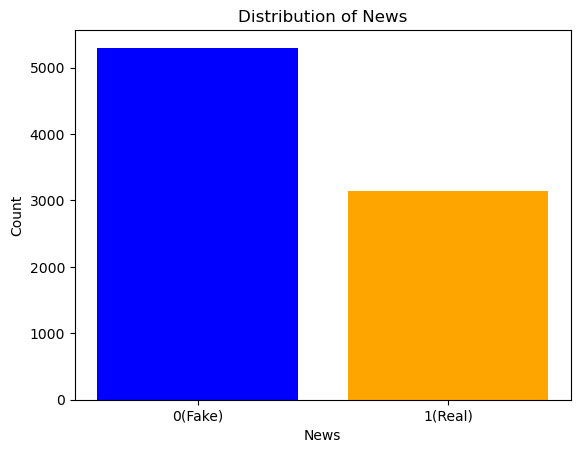

In [13]:
#Check the distribution of labels to see if dataset is balanced
label_counts = combined_df['binary_label'].value_counts()

# Create a bar chart
plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange'])

# Set x-axis ticks and labels
plt.xticks([0, 1], ['0(Fake)', '1(Real)'])

# Add labels and title
plt.xlabel('News')
plt.ylabel('Count')
plt.title('Distribution of News')

# Show the plot
plt.show()

# Data Splitting

In [14]:
#Convert the columns from list to string
combined_df[feature_columns] = combined_df[feature_columns].astype(str)

#Combine text from multiple features into one column
combined_df['features_combined'] = combined_df[feature_columns].apply(lambda row: ' '.join(row), axis=1)

#Assign X and y values
X = combined_df['features_combined'].values
y = combined_df['binary_label'].values

#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Apply oversampling to the training set
oversampler = RandomOverSampler()
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train.reshape(-1, 1), y_train) 

In [15]:
#Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.7)

#Vectorize oversampled training set
X_train_resampled_tfidf = tfidf_vectorizer.fit_transform(X_train_resampled.flatten())

#Vectorize testing set
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Classifier Implementation

In [16]:
#Instantiate Logisitc Regression classifier
lr_Classifier = LogisticRegression()

#Define hyperparameter grids for Logisitc Regression classifier
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

#Perform grid search to search thorugh each combination of hyperparameters
grid_search = GridSearchCV(lr_Classifier, lr_param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled_tfidf, y_train_resampled)

#Get the best parameters for Logisitc Regression classifier
best_param_lr = grid_search.best_params_
print("Best Hyperparameters:", best_param_lr)

#Get the best score of Logisitc Regression classifier
best_score_lr = grid_search.best_score_
print("Best Score:", best_score_lr)

#Train Logistic Regression model with the best hyperparameters
best_lr_Classifier = LogisticRegression(**best_param_lr)
best_lr_Classifier.fit(X_train_resampled_tfidf, y_train_resampled)

Best Hyperparameters: {'C': 100, 'penalty': 'l2'}
Best Score: 0.7352510979700523


LogisticRegression(C=100)

In [17]:
#Instantiate Naive Bayes classifier
nb_Classifier = MultinomialNB()

#Define hyperparameter grid for Naive Bayes classifier
nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0]
}

#Perform grid search to search thorugh each combination of hyperparameters
grid_search = GridSearchCV(nb_Classifier, nb_param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled_tfidf, y_train_resampled)

#Get the best parameters for Naive Bayes classifier
best_param_nb = grid_search.best_params_
print("Best Hyperparameters:", best_param_nb)

#Get the best score of Naive Bayes classifier
best_score_nb = grid_search.best_score_
print("Best Score:", best_score_nb)

#Train Naive Bayes model with the best hyperparameters
best_nb_Classifier = MultinomialNB(**best_param_nb)
best_nb_Classifier.fit(X_train_resampled_tfidf, y_train_resampled)

Best Hyperparameters: {'alpha': 0.1}
Best Score: 0.6961970467199226


MultinomialNB(alpha=0.1)

In [18]:
#Instantiate Passive Aggressive classifier
pa_Classifier = PassiveAggressiveClassifier()

#Define hyperparameter grids for Passive Aggressive classifier
pa_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False]
}

#Perform grid search to search thorugh each combination of hyperparameters
grid_search = GridSearchCV(pa_Classifier, pa_param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled_tfidf, y_train_resampled)

#Get the best parameters for Passive Aggressive classifier
best_param_pa = grid_search.best_params_
print("Best Hyperparameters:", best_param_pa)

#Get the best score of Passive Aggressive classifier
best_score_pa = grid_search.best_score_
print("Best Score:", best_score_pa)

#Train Passive Aggresive model with the best hyperparameters
best_pa_Classifier = PassiveAggressiveClassifier(**best_param_pa)
best_pa_Classifier.fit(X_train_resampled_tfidf, y_train_resampled)

Best Hyperparameters: {'C': 100, 'fit_intercept': False}
Best Score: 0.73760251755023


PassiveAggressiveClassifier(C=100, fit_intercept=False)

In [19]:
#Instantiate K-Nearest Neighbours classifier
knn_Classifier = KNeighborsClassifier()

#Define hyperparameter grids for K-Nearest Neighbours classifier
knn_param_grid = {
    'n_neighbors': list(range(1, 11, 2)),
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

#Perform grid search to search thorugh each combination of hyperparameters
grid_search = GridSearchCV(knn_Classifier, knn_param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled_tfidf, y_train_resampled)

#Get the best parameters for K-Nearest Neighbours classifier
best_param_knn = grid_search.best_params_
print("Best Hyperparameters:", best_param_knn)

#Get the best score of K-Nearest Neighbours classifier
best_score_knn = grid_search.best_score_
print("Best Score:", best_score_knn)

#Train K-Nearest Neighbours model with the best hyperparameters
best_knn_Classifier = KNeighborsClassifier(**best_param_knn)
best_knn_Classifier.fit(X_train_resampled_tfidf, y_train_resampled)

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 1}
Best Score: 0.7546571221081024


KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [20]:
#Instantiate Support Vector Machine classifier
svm_Classifier = SVC()

#Define hyperparameter grids for Support Vector Machine classifier
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

#Perform grid search to search thorugh each combination of hyperparameters
grid_search = GridSearchCV(svm_Classifier, svm_param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled_tfidf, y_train_resampled)

#Get the best parameters for Support Vector Machine classifier
best_param_svm = grid_search.best_params_
print("Best Hyperparameters:", best_param_svm)

#Get the best score of Support Vector Machine classifier
best_score_svm = grid_search.best_score_
print("Best Score:", best_score_svm)

#Train Support Vector Machine model with the best hyperparameters
best_svm_Classifier = SVC(**best_param_svm)
best_svm_Classifier.fit(X_train_resampled_tfidf, y_train_resampled)

Best Hyperparameters: {'C': 1, 'kernel': 'poly'}
Best Score: 0.8408814883978282


SVC(C=1, kernel='poly')

In [21]:
#Instantiate Random Forest classifier
rf_Classifier = RandomForestClassifier()

#Define hyperparameter grids for Random Forest classifier
rf_param_grid = {
    'n_estimators': [10, 100, 1000],
    'max_depth': [None, 10, 20]
}

#Perform grid search to search thorugh each combination of hyperparameters
grid_search = GridSearchCV(rf_Classifier, rf_param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled_tfidf, y_train_resampled)

#Get the best parameters for Random Forest classifier
best_param_rf = grid_search.best_params_
print("Best Hyperparameters:", best_param_rf)

#Get the best score of Random Forest classifier
best_score_rf = grid_search.best_score_
print("Best Score:", best_score_rf)

#Train Random Forest model with the best hyperparameters
best_rf_Classifier = RandomForestClassifier(**best_param_rf)
best_rf_Classifier.fit(X_train_resampled_tfidf, y_train_resampled)

Best Hyperparameters: {'max_depth': None, 'n_estimators': 100}
Best Score: 0.7888851540616246


RandomForestClassifier()

In [22]:
#Define base models using the best hyperparameters
base_models = [
    ('lr', LogisticRegression(**best_param_lr)),
    ('nb', MultinomialNB(**best_param_nb)),
    ('pa', PassiveAggressiveClassifier(**best_param_pa)),
    ('svm', SVC(**best_param_svm)),
    ('knn', KNeighborsClassifier(**best_param_knn))
]

#Define meta model using the best hyperparameters
meta_model = RandomForestClassifier(**best_param_rf)

#Train Stacked Ensemble model
best_se_Classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model)
best_se_Classifier.fit(X_train_resampled_tfidf, y_train_resampled)

StackingClassifier(estimators=[('lr', LogisticRegression(C=100)),
                               ('nb', MultinomialNB(alpha=0.1)),
                               ('pa',
                                PassiveAggressiveClassifier(C=100,
                                                            fit_intercept=False)),
                               ('svm', SVC(C=1, kernel='poly')),
                               ('knn',
                                KNeighborsClassifier(metric='manhattan',
                                                     n_neighbors=1))],
                   final_estimator=RandomForestClassifier())

# Model Evaluation

Training Accuracy: 0.9827099505998589
Test Accuracy: 0.5859004739336493
Test Precision: 0.45440729483282677
Test Recall: 0.4679186228482003
Test F1 Score: 0.4610639938319198


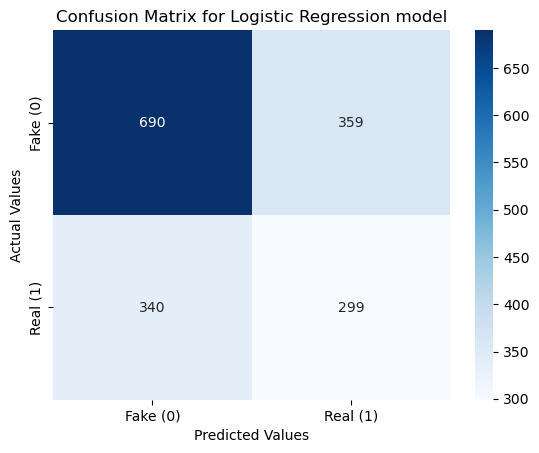

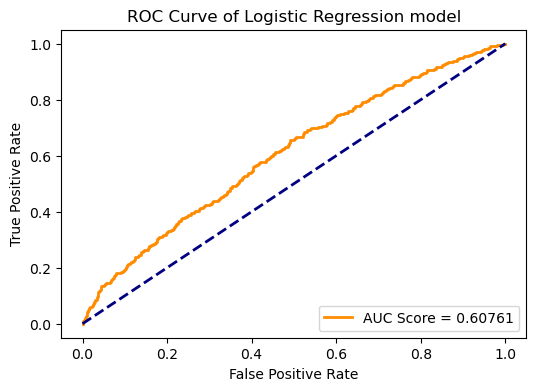

In [23]:
#Evaluate the Logistic Regression model on training set
y_train_pred = best_lr_Classifier.predict(X_train_resampled_tfidf)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print("Training Accuracy:", train_accuracy)

#Evaluate the Logistic Regression model on test set
y_test_pred = best_lr_Classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

#Calculate ROC curve and AUC score of Logistic Regression model
y_test_prob = best_lr_Classifier.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

#Create confusion matrix for Logistic Regression model
cf_matrix =confusion_matrix(y_test, y_test_pred)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
ax.set_xlabel('Predicted Values');
ax.set_ylabel('Actual Values');
ax.set_title('Confusion Matrix for Logistic Regression model');
ax.xaxis.set_ticklabels(['Fake (0)', 'Real (1)']); ax.yaxis.set_ticklabels(['Fake (0)', 'Real (1)']);

#Plot ROC curve of Logistic Regression model
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC Score = {roc_auc:.5f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Regression model')
plt.legend(loc='lower right')
plt.show()

Training Accuracy: 0.8620324629498941
Test Accuracy: 0.6095971563981043
Test Precision: 0.48493975903614456
Test Recall: 0.5039123630672926
Test F1 Score: 0.4942440521872601


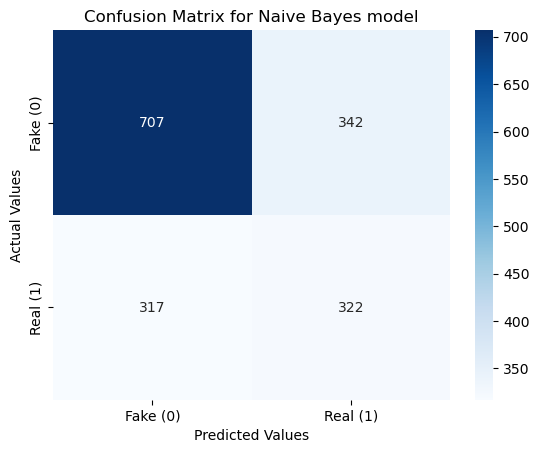

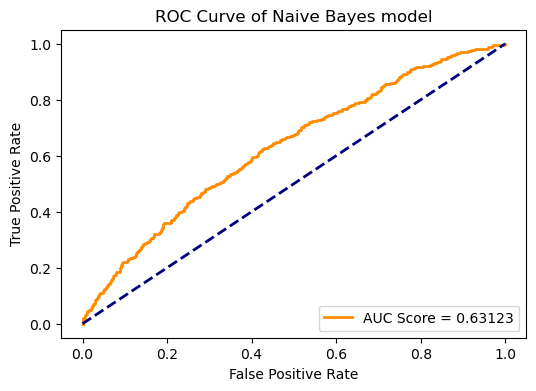

In [24]:
#Evaluate the Naive Bayes model on training set
y_train_pred = best_nb_Classifier.predict(X_train_resampled_tfidf)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print("Training Accuracy:", train_accuracy)

#Evaluate the Naive Bayes model on test set
y_test_pred = best_nb_Classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

#Calculate ROC curve and AUC score of Naive Bayes model
y_test_prob = best_nb_Classifier.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

#Create confusion matrix for Naive Bayes model
cf_matrix =confusion_matrix(y_test, y_test_pred)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
ax.set_xlabel('Predicted Values');
ax.set_ylabel('Actual Values');
ax.set_title('Confusion Matrix for Naive Bayes model');
ax.xaxis.set_ticklabels(['Fake (0)', 'Real (1)']); ax.yaxis.set_ticklabels(['Fake (0)', 'Real (1)']);

#Plot ROC curve of Naive Bayes model
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC Score = {roc_auc:.5f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Naive Bayes model')
plt.legend(loc='lower right')
plt.show()

Training Accuracy: 0.999176664314279
Test Accuracy: 0.5811611374407583
Test Precision: 0.4473684210526316
Test Recall: 0.4522691705790297
Test F1 Score: 0.44980544747081713


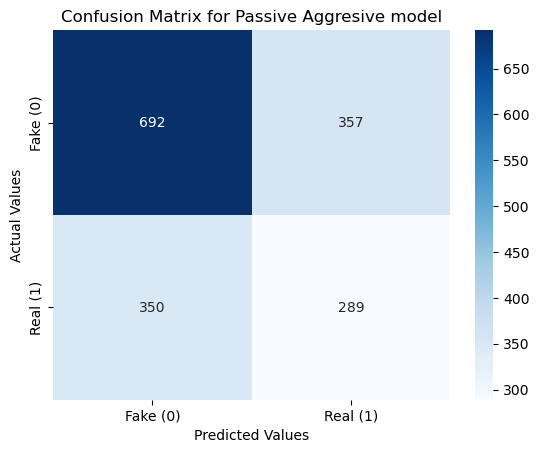

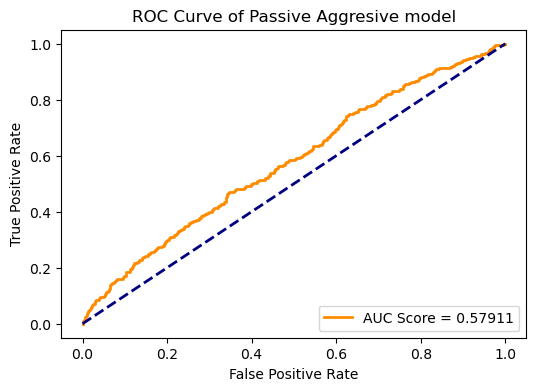

In [25]:
#Evaluate the Passive Aggresive model on training set
y_train_pred = best_pa_Classifier.predict(X_train_resampled_tfidf)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print("Training Accuracy:", train_accuracy)

#Evaluate the Passive Aggresive model on test set
y_test_pred = best_pa_Classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

#Calculate ROC curve and AUC score of Passive Aggresive model
y_test_prob = best_pa_Classifier.decision_function(X_test_tfidf)
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

#Create confusion matrix for Passive Aggresive model
cf_matrix =confusion_matrix(y_test, y_test_pred)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
ax.set_xlabel('Predicted Values');
ax.set_ylabel('Actual Values');
ax.set_title('Confusion Matrix for Passive Aggresive model');
ax.xaxis.set_ticklabels(['Fake (0)', 'Real (1)']); ax.yaxis.set_ticklabels(['Fake (0)', 'Real (1)']);

#Plot ROC curve of Passive Aggresive model
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC Score = {roc_auc:.5f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Passive Aggresive model')
plt.legend(loc='lower right')
plt.show()

Training Accuracy: 1.0
Test Accuracy: 0.5977488151658767
Test Precision: 0.4633699633699634
Test Recall: 0.39593114241001565
Test F1 Score: 0.42700421940928274


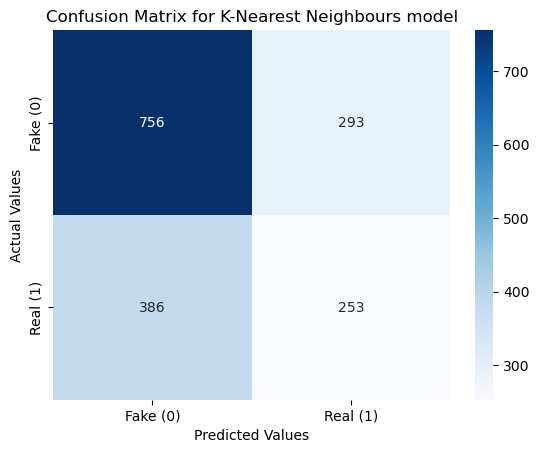

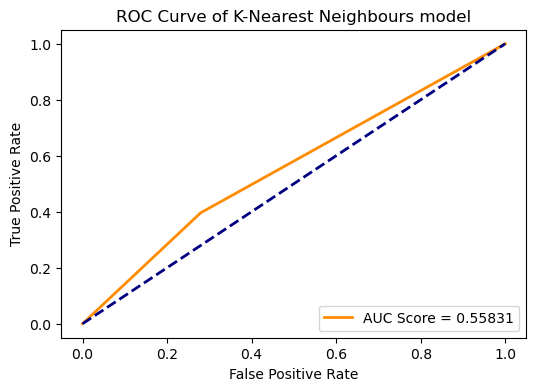

In [26]:
#Evaluate the K-Nearest Neighbours model on training set
y_train_pred = best_knn_Classifier.predict(X_train_resampled_tfidf)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print("Training Accuracy:", train_accuracy)

#Evaluate the K-Nearest Neighbours model on test set
y_test_pred = best_knn_Classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

#Calculate ROC curve and AUC score of K-Nearest Neighbours model
y_test_prob = best_knn_Classifier.predict_proba(X_test_tfidf)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

#Create confusion matrix for K-Nearest Neighbours model
cf_matrix =confusion_matrix(y_test, y_test_pred)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
ax.set_xlabel('Predicted Values');
ax.set_ylabel('Actual Values');
ax.set_title('Confusion Matrix for K-Nearest Neighbours model');
ax.xaxis.set_ticklabels(['Fake (0)', 'Real (1)']); ax.yaxis.set_ticklabels(['Fake (0)', 'Real (1)']);

#Plot ROC curve of K-Nearest Neighbours model
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC Score = {roc_auc:.5f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of K-Nearest Neighbours model')
plt.legend(loc='lower right')
plt.show()

Training Accuracy: 0.9996471418489767
Test Accuracy: 0.6303317535545023
Test Precision: 0.6
Test Recall: 0.07042253521126761
Test F1 Score: 0.12605042016806722


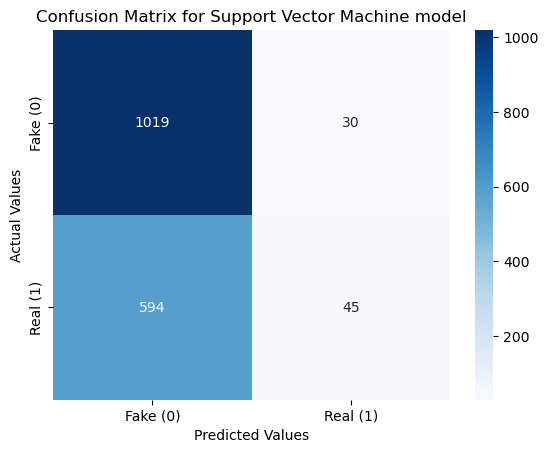

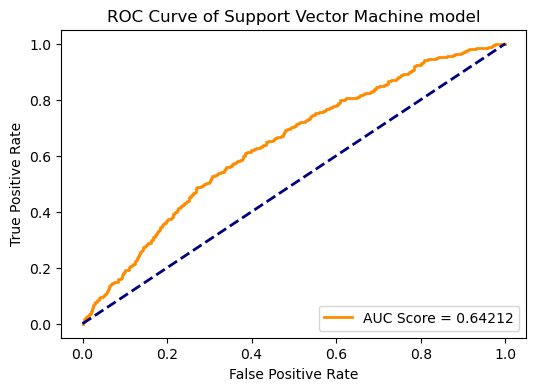

In [27]:
#Evaluate the Support Vector Machine model on training set
y_train_pred = best_svm_Classifier.predict(X_train_resampled_tfidf)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print("Training Accuracy:", train_accuracy)

#Evaluate the Support Vector Machine model on test set
y_test_pred = best_svm_Classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

#Calculate ROC curve and AUC score of Support Vector Machine model
y_test_prob = best_svm_Classifier.decision_function(X_test_tfidf)
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

#Create confusion matrix for Support Vector Machine model
cf_matrix =confusion_matrix(y_test, y_test_pred)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
ax.set_xlabel('Predicted Values');
ax.set_ylabel('Actual Values');
ax.set_title('Confusion Matrix for Support Vector Machine model');
ax.xaxis.set_ticklabels(['Fake (0)', 'Real (1)']); ax.yaxis.set_ticklabels(['Fake (0)', 'Real (1)']);

#Plot ROC curve of Support Vector Machine model
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC Score = {roc_auc:.5f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Support Vector Machine model')
plt.legend(loc='lower right')
plt.show()

Training Accuracy: 1.0
Test Accuracy: 0.6528436018957346
Test Precision: 0.5644768856447688
Test Recall: 0.36306729264475746
Test F1 Score: 0.4419047619047619


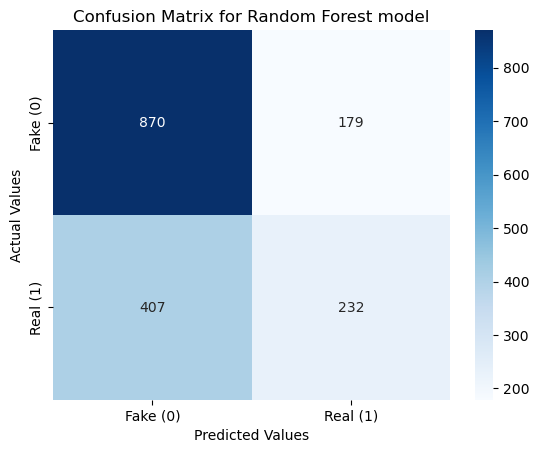

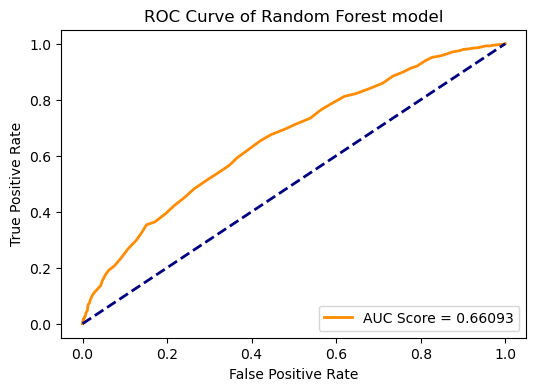

In [28]:
#Evaluate the Random Forest model on training set
y_train_pred = best_rf_Classifier.predict(X_train_resampled_tfidf)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print("Training Accuracy:", train_accuracy)

#Evaluate the Random Forest model on test set
y_test_pred = best_rf_Classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

#Calculate ROC curve and AUC score of Random Forest model
y_test_prob = best_rf_Classifier.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

#Create confusion matrix for Random Forest model
cf_matrix =confusion_matrix(y_test, y_test_pred)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
ax.set_xlabel('Predicted Values');
ax.set_ylabel('Actual Values');
ax.set_title('Confusion Matrix for Random Forest model');
ax.xaxis.set_ticklabels(['Fake (0)', 'Real (1)']); ax.yaxis.set_ticklabels(['Fake (0)', 'Real (1)']);

#Plot ROC curve of Random Forest model
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC Score = {roc_auc:.5f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Random Forest model')
plt.legend(loc='lower right')
plt.show()

Training Accuracy: 0.9941190308162785
Test Accuracy: 0.6214454976303317
Test Precision: 0.5
Test Recall: 0.051643192488262914
Test F1 Score: 0.09361702127659575


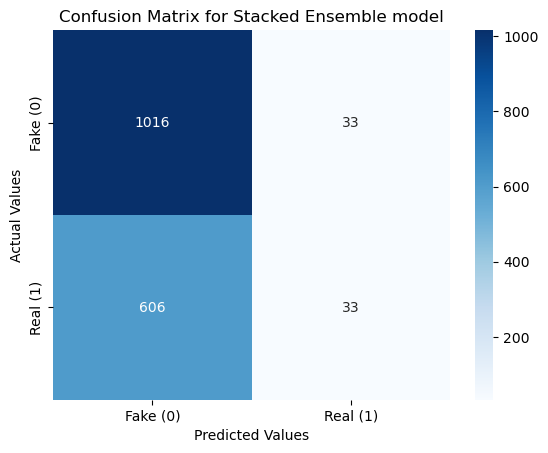

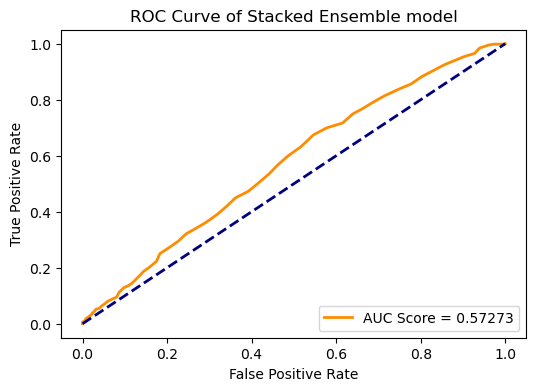

In [29]:
#Evaluate the Stacked Ensemble model on training set
y_train_pred = best_se_Classifier.predict(X_train_resampled_tfidf)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print("Training Accuracy:", train_accuracy)

#Evaluate the Stacked Ensemble model on test set
y_test_pred = best_se_Classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

#Calculate ROC curve and AUC score of Stacked Ensemble model
y_test_prob = best_se_Classifier.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

#Create confusion matrix for Stacked Ensemble model
cf_matrix =confusion_matrix(y_test, y_test_pred)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
ax.set_xlabel('Predicted Values');
ax.set_ylabel('Actual Values');
ax.set_title('Confusion Matrix for Stacked Ensemble model');
ax.xaxis.set_ticklabels(['Fake (0)', 'Real (1)']); ax.yaxis.set_ticklabels(['Fake (0)', 'Real (1)']);

#Plot ROC curve of Stacked Ensemble model
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC Score = {roc_auc:.5f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Stacked Ensemble model')
plt.legend(loc='lower right')
plt.show()